# TTC Subway Delay Prediction Notebook Using PyTorch

This notebook demonstrates how to build a **multi-output** neural network in **PyTorch** to predict:
1. **Delay Probability** (binary classification)
2. **Delay Length** (regression)

We assume a CSV file (`/mnt/data/subway-data.csv`) containing:
- **Time** (in 24-hour format, e.g., "13:45")
- **Station** (e.g., "Rosedale Station")
- **Min Delay** (integer or float representing delay in minutes)

## Notebook Steps
1. **Load & Preprocess Data**: Convert `Time` to a normalized feature and encode `Station` into integer IDs.
2. **Create Dataset & DataLoader**: For efficient batching.
3. **Build PyTorch Model**: With an embedding layer for stations, shared layers, and two heads.
4. **Train**: Using a combined loss (binary cross-entropy + MSE).
5. **Evaluate**: Track accuracy for delay probability and MAE for delay length.
6. **Precompute Predictions**: Generate predictions over a grid of times and stations for frontend use.


In [25]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 1. Load CSV and Basic Preprocessing
We assume `/mnt/data/subway-data.csv` has at least these columns:
- **Time**: 24-hour format (e.g., "13:45")
- **Station**: Station name
- **Min Delay**: Delay in minutes

We convert `Time` to a normalized float (`time_norm`) between 0.0 and 1.0. We also factorize `Station` into integer IDs for embedding.

In [26]:
pd.set_option("display.max_rows", None)
# Load CSV
df_2021_01 = pd.read_csv('subway-data-2021-01.csv')
df_2021_02 = pd.read_csv('subway-data-2021-02.csv')
df_2021_03 = pd.read_csv('subway-data-2021-03.csv')
df_2021_04 = pd.read_csv('subway-data-2021-04.csv')
df_2021_05 = pd.read_csv('subway-data-2021-05.csv')
df_2021_06 = pd.read_csv('subway-data-2021-06.csv')
df_2021_07 = pd.read_csv('subway-data-2021-07.csv')
df_2021_08 = pd.read_csv('subway-data-2021-08.csv')
df_2021_09 = pd.read_csv('subway-data-2021-09.csv')
df_2021_10 = pd.read_csv('subway-data-2021-10.csv')
df_2021_11 = pd.read_csv('subway-data-2021-11.csv')
df_2021_12 = pd.read_csv('subway-data-2021-12.csv')

df_2021 = pd.concat([df_2021_01, df_2021_02, df_2021_03, df_2021_04, df_2021_05, df_2021_06, df_2021_07, df_2021_08, df_2021_09, df_2021_10, df_2021_11, df_2021_12])
df_2023 = pd.read_csv('subway-data-2023.csv')
df_2022 = pd.read_csv('subway-data-2022.csv')
df_2024 = pd.read_csv('subway-data-2024.csv')

df = pd.concat([df_2021, df_2022, df_2023, df_2024])

# print("Data sample:\n", df.head(), "\n")

# delete SRT (discontinued line), and other unknown lines since theres so little so it won't affect the data (109 Ranee,
# Track level actitivty)
remove_lines = ["SRT", "109 RANEE", "TRACK LEVEL ACTIVITY", "YU/BD/SHP"]
df = df[~df["Line"].isin(remove_lines)]
df["Line"].value_counts()

# drop unneeded columns
df = df.drop(columns=['Date', 'Day', 'Code', 'Min Gap', 'Bound', 'Line', 'Vehicle'])
# Drop rows where Min Delay is 0
df = df[df['Min Delay'] > 0]

# remove random stations or those that don't actually correspond to a normal subway station
remove_stations = ["111 SPADINA ROAD", "1900 YONGE MCBRIEN BLD", "1900 YONGE ST- MCBRIEN", "2233 SHEPPARD WEST", "ALL STATIONS", "BLOOR DANFORTH LINE", "YONGE UNIVERSITY LINE", "YONGE UNIVERSITY SUBWA", "EGLINTON STATION (MIGR", "TORONTO TRANSIT COMMIS"]
df = df[~df["Station"].isin(remove_stations)]
df = df[~df["Station"].str.contains("app|yard| to |towards", case=False)]

# rename stations with "BD" in their name to remove "BD" and any space before it
df["Station"] = df["Station"].str.replace(" BD STATION", " STATION", regex=False)
df["Station"] = df["Station"].str.replace(" YUS STATION", " STATION", regex=False)
df["Station"] = df["Station"].str.replace("ST. ", "ST ", regex=False)

# rename stations with typos and group davisville into one station (seems too statistically insignificant to drop)
df.loc[df["Station"] == "PIONEER VILLAGE STATIO", "Station"] = "PIONEER VILLAGE STATION"
df.loc[df["Station"] == "YORK UNIVERSITY STATIO", "Station"] = "YORK UNIVERSITY STATION"
df.loc[df["Station"] == "DAVISVILLE BUILD UP", "Station"] = "DAVISVILLE STATION"
df.loc[df["Station"] == "SHEPPARD STATION", "Station"] = "SHEPPARD-YONGE STATION"

# rename bloor yonge into a single station
df.loc[df["Station"] == "BLOOR STATION", "Station"] = "BLOOR-YONGE STATION"
df.loc[df["Station"] == "YONGE STATION", "Station"] = "BLOOR-YONGE STATION"
df.loc[df["Station"] == "YONGE-UNIVERSITY AND B", "Station"] = "BLOOR-YONGE STATION"
df.loc[df["Station"] == "YONGE/UNIVERSITY AND B", "Station"] = "BLOOR-YONGE STATION"


# remove stations with fewer than 50 occurrences
station_counts = df["Station"].value_counts()
stations_to_remove = station_counts[station_counts < 50].index.tolist()
df = df[~df["Station"].isin(stations_to_remove)]

print(df["Station"].value_counts())
print("Data sample:\n", df.head(), "\n")

# Save the preprocessed dataframe to a new CSV file (debugging)
output_path = 'subway-data-preprocessed.csv'
df.to_csv(output_path, index=False)
print(f"Preprocessed data saved to {output_path}")

# Convert 'Time' to datetime
df['Time_dt'] = pd.to_datetime(df['Time'], format='%H:%M', errors='coerce')

# Adjust time normalization to match TTC operating hours (6AM to 1:30AM)
# First, convert to minutes since midnight
minutes_since_midnight = df['Time_dt'].dt.hour * 60 + df['Time_dt'].dt.minute

# Define TTC operating hours in minutes
start_time_minutes = 6 * 60  # 6AM
end_time_minutes = 25 * 60 + 30  # 1:30AM next day (represented as 25:30)

# Handle time after midnight but before 1:30AM
df['minutes_since_6am'] = minutes_since_midnight.copy()
# For times after midnight but before 1:30AM, add 24 hours worth of minutes
df.loc[df['Time_dt'].dt.hour < 6, 'minutes_since_6am'] += 24 * 60

# Normalize time to [0, 1] based on operating hours
df['time_norm'] = (df['minutes_since_6am'] - start_time_minutes) / (end_time_minutes - start_time_minutes)
# Clamp values to ensure they're between 0 and 1
df['time_norm'] = df['time_norm'].clip(0, 1)

# Encode station names as integer IDs
df['station_encoded'], station_mapping = pd.factorize(df['Station'])
num_stations = df['station_encoded'].nunique()
print("Number of unique stations:", num_stations)

# Create delay severity categories (optional)
df['delay_severity'] = pd.cut(
    df['Min Delay'], 
    bins=[-0.1, 1, 5, 15, float('inf')],
    labels=['Minimal', 'Minor', 'Moderate', 'Severe']
)
print("\nDelay severity distribution:")
print(df['delay_severity'].value_counts())

# For regression, we'll predict the actual delay length
df['y_length'] = df['Min Delay']

print("\nProcessed data sample:\n", df[['time_norm', 'station_encoded', 'y_length', 'delay_severity']].head())


Station
BLOOR-YONGE STATION        1534
FINCH STATION              1509
VAUGHAN MC STATION         1395
EGLINTON STATION           1341
KENNEDY STATION            1240
ST GEORGE STATION          1222
KIPLING STATION            1106
SHEPPARD-YONGE STATION      808
WILSON STATION              801
SPADINA STATION             783
DAVISVILLE STATION          658
ST CLAIR STATION            614
COXWELL STATION             583
ROSEDALE STATION            580
DUNDAS STATION              542
UNION STATION               514
LAWRENCE STATION            513
SHEPPARD WEST STATION       512
YORK MILLS STATION          511
ST CLAIR WEST STATION       508
WARDEN STATION              508
WELLESLEY STATION           471
KEELE STATION               465
VICTORIA PARK STATION       443
GREENWOOD STATION           441
COLLEGE STATION             439
YORKDALE STATION            408
HIGHWAY 407 STATION         392
QUEEN STATION               361
BROADVIEW STATION           355
SUMMERHILL STATION          351


## 2. Prepare Train/Test Split & PyTorch Dataset
We'll extract the features:
- `time_norm` (as a float32)
- `station_encoded` (as a long/int64 for embedding)
Then create two targets:
- `y_prob` (float32, binary 0 or 1)
- `y_length` (float32, continuous)

We'll split the dataset using `train_test_split` and wrap it into a `Dataset` + `DataLoader`.

In [27]:
# Prepare arrays
X_time = df['time_norm'].values.reshape(-1, 1)
X_station = df['station_encoded'].values.reshape(-1, 1)
y_length = df['y_length'].values.reshape(-1, 1).astype(np.float32)

# One-hot encode delay severity for multi-class classification
from sklearn.preprocessing import OneHotEncoder
# Update parameter name from 'sparse' to 'sparse_output' for newer scikit-learn versions
encoder = OneHotEncoder(sparse_output=False)
y_severity = encoder.fit_transform(df['delay_severity'].values.reshape(-1, 1))

# Standardize the delay length for better regression performance
scaler = StandardScaler()
y_length_scaled = scaler.fit_transform(y_length)

# Create time features: sin and cos for time of day (using operating hours cycle)
operating_hours = 19.5  # 6AM to 1:30AM is 19.5 hours
X_time_sin = np.sin(2 * np.pi * X_time)
X_time_cos = np.cos(2 * np.pi * X_time)
X_time_feats = np.concatenate([X_time, X_time_sin, X_time_cos], axis=1)

# Train/test split - stratify by delay severity to ensure balanced distribution
from sklearn.model_selection import train_test_split
X_time_train, X_time_test, X_station_train, X_station_test, \
y_length_train, y_length_test, y_severity_train, y_severity_test = train_test_split(
    X_time_feats, X_station, y_length_scaled, y_severity, 
    test_size=0.2, random_state=42, 
    stratify=df['delay_severity'].values
)

class SubwayDelayDataset(Dataset):
    def __init__(self, X_time, X_station, y_length, y_severity):
        self.X_time = torch.tensor(X_time, dtype=torch.float32)
        self.X_station = torch.tensor(X_station, dtype=torch.long)
        self.y_length = torch.tensor(y_length, dtype=torch.float32)
        self.y_severity = torch.tensor(y_severity, dtype=torch.float32)

    def __len__(self):
        return len(self.X_time)

    def __getitem__(self, idx):
        return (
            self.X_time[idx],
            self.X_station[idx],
            self.y_length[idx],
            self.y_severity[idx]
        )

# Create Dataset objects
train_dataset = SubwayDelayDataset(X_time_train, X_station_train, y_length_train, y_severity_train)
test_dataset = SubwayDelayDataset(X_time_test, X_station_test, y_length_test, y_severity_test)

# Create DataLoaders with a larger batch size for better training stability
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

## 3. Define the Multi-Output PyTorch Model
We'll use:
- An **embedding layer** for station IDs.
- A small feed-forward network.
- Two separate heads: one for classification (sigmoid) and one for regression (linear).

In [20]:
class MultiOutputModel(nn.Module):
    def __init__(self, num_stations, num_severity_classes=4, embedding_dim=16, time_features=3):
        super(MultiOutputModel, self).__init__()
        self.station_embedding = nn.Embedding(num_stations, embedding_dim)
        
        # Input dimension = time_features (time, sin, cos) + embedding_dim (station)
        input_dim = time_features + embedding_dim
        
        # Shared layers with batch normalization
        self.shared_layers = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Delay severity classification head (multi-class)
        self.severity_layers = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_severity_classes),
            nn.Softmax(dim=1)
        )
        
        # Delay length head (regression)
        self.length_layers = nn.Sequential(
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, time_input, station_input):
        # Remove the extra dimension: from [batch_size, 1] to [batch_size]
        station_input = station_input.squeeze(1)
        # Now, station_embed will be of shape [batch_size, embedding_dim]
        station_embed = self.station_embedding(station_input).float()
        
        # Concatenate time_input with station_embed
        x = torch.cat([time_input, station_embed], dim=1)
        
        # Shared features
        shared_features = self.shared_layers(x)
        
        # Output heads
        out_severity = self.severity_layers(shared_features)
        out_length = self.length_layers(shared_features)
        
        return out_severity, out_length

# Increased embedding dimension for better station representation
embedding_dim = 16
# Account for additional time features
time_features = 3
num_severity_classes = len(encoder.categories_[0])
model = MultiOutputModel(num_stations=num_stations, num_severity_classes=num_severity_classes, embedding_dim=embedding_dim, time_features=time_features).to(device)
print(model)

MultiOutputModel(
  (station_embedding): Embedding(70, 16)
  (shared_layers): Sequential(
    (0): Linear(in_features=19, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (severity_layers): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=3, bias=True)
    (3): Softmax(dim=1)
  )
  (length_layers): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=1, bias=True)
  )
)


## 4. Loss Functions, Optimizer, and Training Loop
We'll combine:
- **BCELoss** (binary cross-entropy) for delay probability
- **MSELoss** for delay length

We simply add these two losses. You could weight them if one is more important.

In [ ]:
# Loss functions for multi-task learning
ce_loss = nn.CrossEntropyLoss()  # For severity classification
mse_loss = nn.MSELoss()          # For delay length regression

# Weights for multi-task loss balancing
severity_loss_weight = 0.6
length_loss_weight = 0.4

# Optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# Learning rate scheduler to reduce learning rate when validation loss plateaus
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 100
train_losses = []
val_losses = []
val_severity_accuracy = []
val_maes = []

# Variables for early stopping
best_val_loss = float('inf')
best_model_wts = None
patience = 7
no_improve_epochs = 0

for epoch in range(num_epochs):
    # ------------------
    # TRAIN
    # ------------------
    model.train()
    running_train_loss = 0.0
    for batch in train_loader:
        time_batch, station_batch, length_batch, severity_batch = batch
        time_batch = time_batch.to(device)
        station_batch = station_batch.to(device)
        length_batch = length_batch.to(device)
        severity_batch = severity_batch.to(device)

        optimizer.zero_grad()
        out_severity, out_length = model(time_batch, station_batch)

        # Calculate losses for both tasks
        loss_severity = ce_loss(out_severity, torch.argmax(severity_batch, dim=1))
        loss_length = mse_loss(out_length, length_batch)
        
        # Combined weighted loss
        loss = severity_loss_weight * loss_severity + length_loss_weight * loss_length

        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * time_batch.size(0)

    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    # ------------------
    # VALIDATION
    # ------------------
    model.eval()
    running_val_loss = 0.0
    severity_correct = 0
    total = 0
    total_mae = 0.0

    with torch.no_grad():
        for batch in test_loader:
            time_batch, station_batch, length_batch, severity_batch = batch
            time_batch = time_batch.to(device)
            station_batch = station_batch.to(device)
            length_batch = length_batch.to(device)
            severity_batch = severity_batch.to(device)

            out_severity, out_length = model(time_batch, station_batch)

            # Calculate losses
            loss_severity = ce_loss(out_severity, torch.argmax(severity_batch, dim=1))
            loss_length = mse_loss(out_length, length_batch)
            
            # Combined weighted loss
            loss = severity_loss_weight * loss_severity + length_loss_weight * loss_length
            running_val_loss += loss.item() * time_batch.size(0)

            # Calculate severity classification accuracy
            _, predicted_severity = torch.max(out_severity, 1)
            true_severity = torch.argmax(severity_batch, dim=1)
            severity_correct += (predicted_severity == true_severity).sum().item()
            total += severity_batch.size(0)

            # MAE for length (convert back to original scale)
            mae = torch.abs(out_length - length_batch).sum().item()
            total_mae += mae

    epoch_val_loss = running_val_loss / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    severity_acc = severity_correct / total
    val_severity_accuracy.append(severity_acc)
    
    val_mae = total_mae / total
    val_maes.append(val_mae)

    # Update the learning rate scheduler
    scheduler.step(epoch_val_loss)
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        no_improve_epochs = 0
    else:
        no_improve_epochs += 1
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {epoch_train_loss:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f} | "
          f"Severity Acc: {severity_acc:.4f} | "
          f"Val MAE: {val_mae:.4f} | "
          f"LR: {optimizer.param_groups[0]['lr']:.6f}")
    
    # If no improvement for 'patience' epochs, stop training
    if no_improve_epochs >= patience:
        print(f"Early stopping triggered after {epoch+1} epochs")
        break

# Load the best model
if best_model_wts is not None:
    model.load_state_dict(best_model_wts)
    print("Loaded best model weights")

/opt/homebrew/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


NameError: name 'F' is not defined

## 5. Plot Training Curves
We'll visualize how the **combined training loss**, **validation loss**, **validation accuracy** (for probability),
and **validation MAE** (for length) evolve.

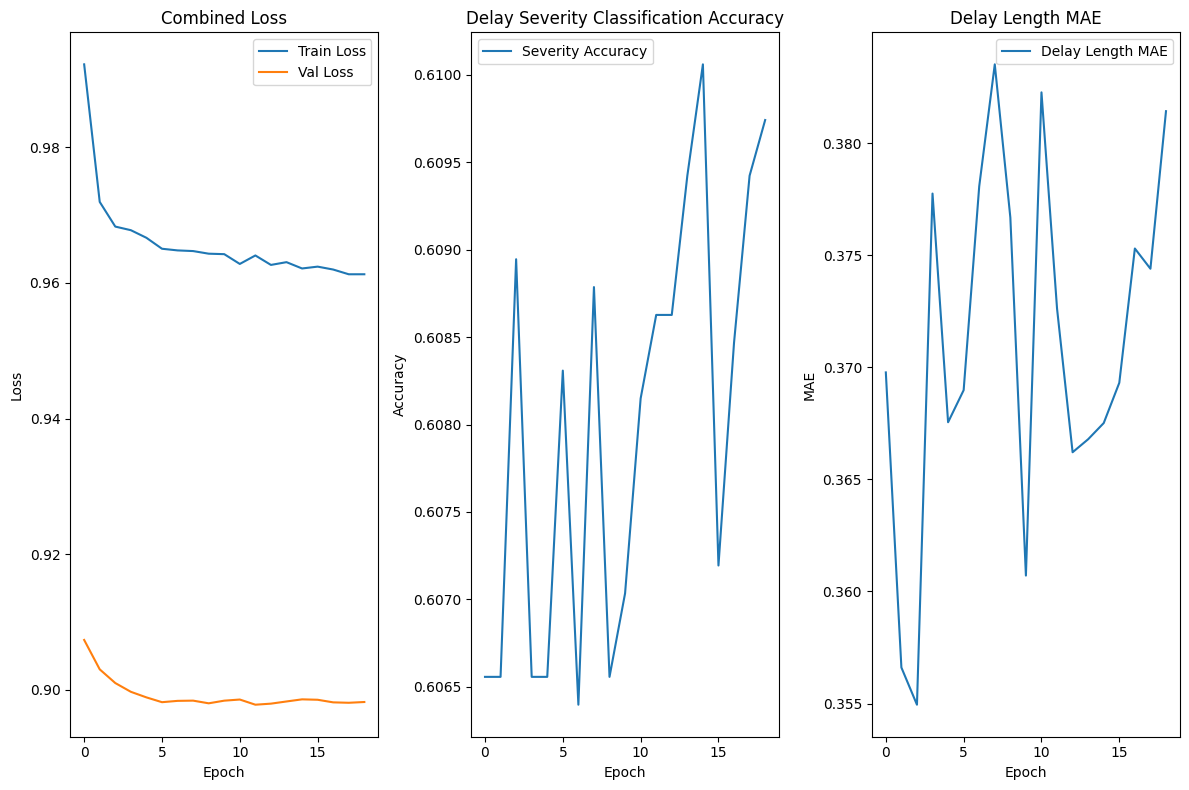

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Combined Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_severity_accuracy, label='Severity Accuracy')
plt.title("Delay Severity Classification Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(val_maes, label='Delay Length MAE')
plt.title("Delay Length MAE")
plt.xlabel("Epoch")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()

## 6. Precompute Predictions for the Frontend
We can generate a grid of times (0.0 to 1.0) and station IDs, run inference, and store them.
In your real app, you might save these to a database or serve them via an API.

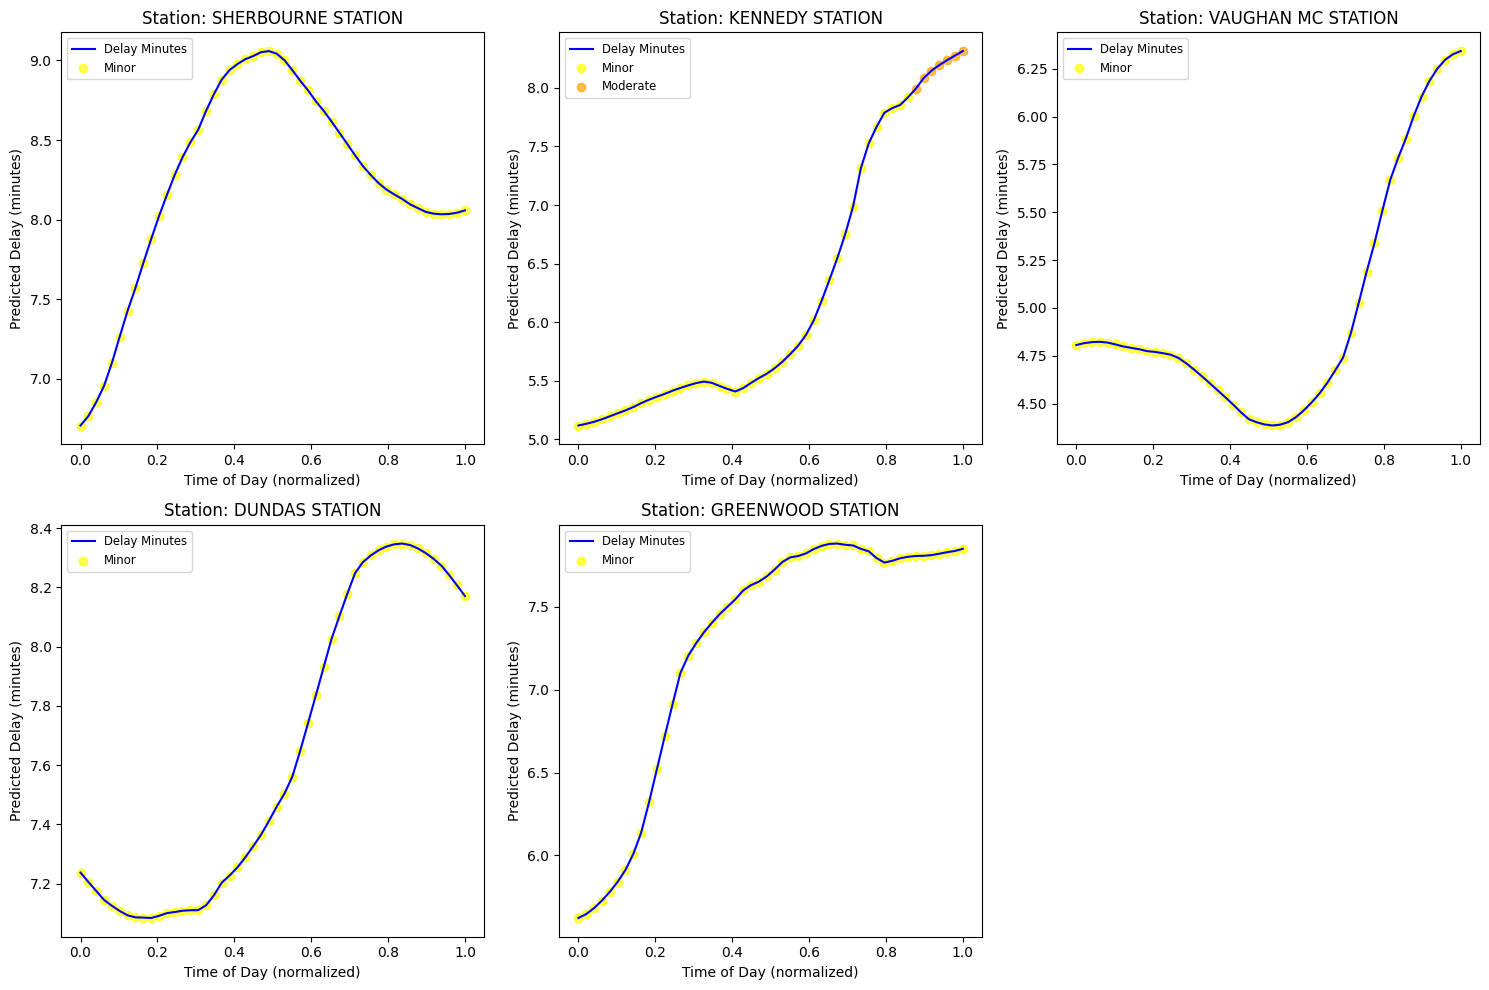


Precomputed Predictions (sample):
   station        station_name  time_norm time_hhmm delay_severity  \
0        0  SHERBOURNE STATION   0.000000     06:00          Minor   
1        0  SHERBOURNE STATION   0.020408     06:23          Minor   
2        0  SHERBOURNE STATION   0.040816     06:47          Minor   
3        0  SHERBOURNE STATION   0.061224     07:11          Minor   
4        0  SHERBOURNE STATION   0.081633     07:35          Minor   

   delay_length  
0      6.707940  
1      6.766787  
2      6.853979  
3      6.956551  
4      7.100383  
Model and predictions saved to files


In [ ]:
# Precompute predictions on a grid of times and stations
# Convert from time norm back to actual time strings
def time_norm_to_hhmm(time_norm):
    """Convert normalized time back to HH:MM format"""
    # Convert normalized time to minutes since 6AM
    total_operating_minutes = (end_time_minutes - start_time_minutes)
    minutes_since_6am = time_norm * total_operating_minutes + start_time_minutes
    
    # Convert to hours and minutes
    hours = int(minutes_since_6am // 60)
    minutes = int(minutes_since_6am % 60)
    
    # Handle hours >= 24 (after midnight)
    if hours >= 24:
        hours -= 24
        
    return f"{hours:02d}:{minutes:02d}"

# Create a grid of times for prediction
time_grid = np.linspace(0, 1, 50).astype(np.float32)
time_grid_sin = np.sin(2 * np.pi * time_grid)
time_grid_cos = np.cos(2 * np.pi * time_grid)
time_grid_feats = np.column_stack([time_grid, time_grid_sin, time_grid_cos])

stations_range = np.arange(num_stations)
predictions = []

model.eval()
with torch.no_grad():
    for station_id in stations_range:
        for i, t in enumerate(time_grid):
            time_input = torch.tensor([time_grid_feats[i]], device=device)
            station_input = torch.tensor([[station_id]], device=device)
            out_severity, out_length = model(time_input, station_input)
            
            # Get predicted severity class
            _, predicted_severity = torch.max(out_severity, 1)
            severity_label = encoder.categories_[0][predicted_severity.item()]
            
            # Convert standardized delay length back to original scale
            delay_length = scaler.inverse_transform(out_length.cpu().numpy().reshape(-1, 1))[0][0]
            
            # Convert normalized time to HH:MM format
            time_hhmm = time_norm_to_hhmm(t)
            
            predictions.append({
                'station': int(station_id),
                'station_name': station_mapping[int(station_id)],
                'time_norm': float(t),
                'time_hhmm': time_hhmm,
                'delay_severity': severity_label,
                'delay_length': float(delay_length)
            })

pred_df = pd.DataFrame(predictions)

# Add a visualization of prediction patterns for a few stations
plt.figure(figsize=(15, 10))
sample_stations = min(5, num_stations)
for i, station_id in enumerate(range(sample_stations)):
    station_preds = pred_df[pred_df['station'] == station_id]
    
    plt.subplot(2, 3, i+1)
    plt.plot(station_preds['time_norm'], station_preds['delay_length'], 'b-', label='Delay Minutes')
    
    # Add color-coded severity points
    severity_colors = {'Minimal': 'green', 'Minor': 'yellow', 'Moderate': 'orange', 'Severe': 'red'}
    for severity in severity_colors:
        severity_points = station_preds[station_preds['delay_severity'] == severity]
        if not severity_points.empty:
            plt.scatter(severity_points['time_norm'], severity_points['delay_length'], 
                      c=severity_colors[severity], label=severity, alpha=0.7)
    
    plt.title(f"Station: {station_preds['station_name'].iloc[0]}")
    plt.xlabel("Time of Day (normalized)")
    plt.ylabel("Predicted Delay (minutes)")
    plt.legend(loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

print("\nPrecomputed Predictions (sample):")
print(pred_df.head())

# Save model and predictions
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'encoder': encoder,
    'station_mapping': station_mapping,
    'num_stations': num_stations,
    'operating_hours': {
        'start_minutes': start_time_minutes,
        'end_minutes': end_time_minutes
    }
}, 'subway_delay_model.pt')

pred_df.to_csv('subway_delay_predictions.csv', index=False)
print("Model and predictions saved to files")

## 7. Additional analysis: Delay severity by time of day

/var/folders/fy/djmb_dfs5sn0ws7zl0m08_g80000gn/T/ipykernel_19226/235633008.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  severity_counts = df.groupby([df['Time_dt'].dt.hour, 'delay_severity']).size().unstack()


<Figure size 1000x600 with 0 Axes>

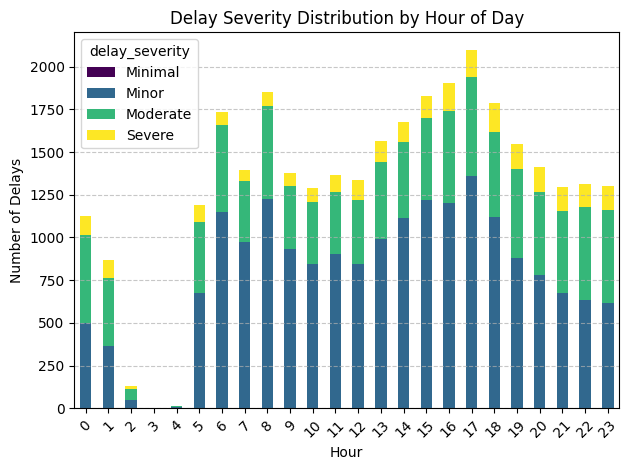

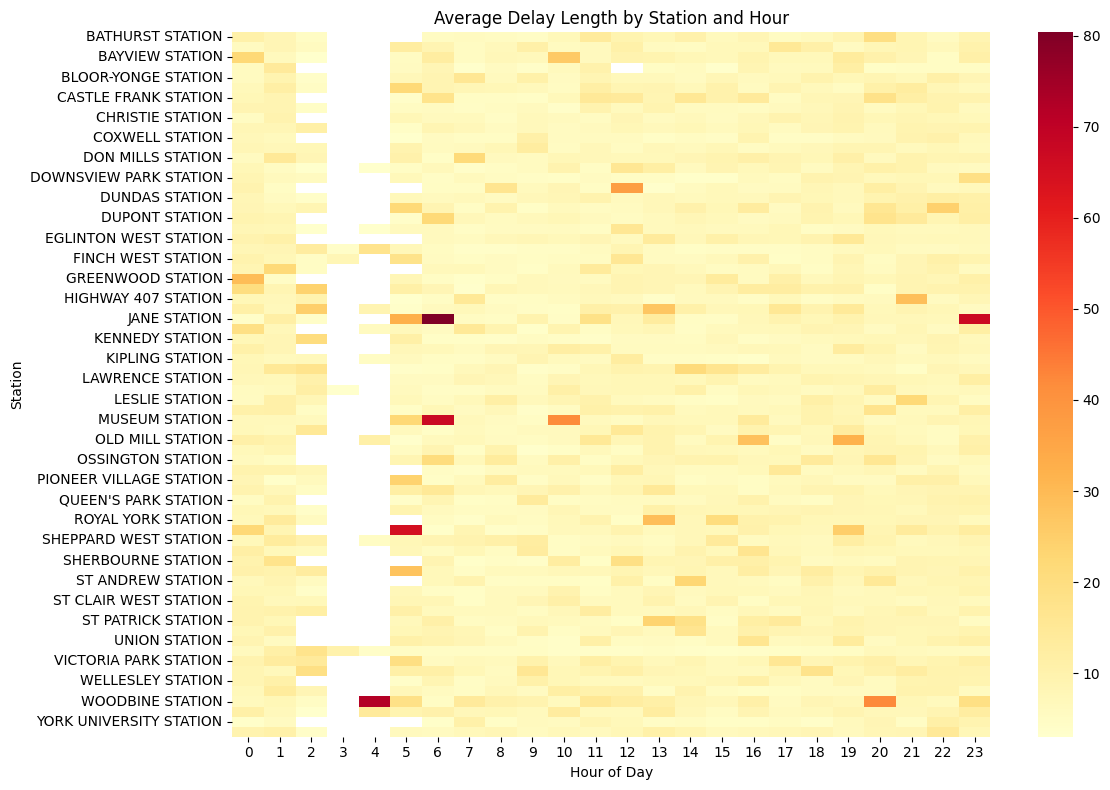

In [ ]:
# Additional analysis: Delay severity by time of day
plt.figure(figsize=(10, 6))
severity_counts = df.groupby([df['Time_dt'].dt.hour, 'delay_severity']).size().unstack()
severity_counts.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Delay Severity Distribution by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Delays')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Heatmap of delay lengths by station and hour
plt.figure(figsize=(12, 8))
station_time_delays = df.pivot_table(
    values='Min Delay', 
    index='Station', 
    columns=df['Time_dt'].dt.hour,
    aggfunc='mean'
)
import seaborn as sns
sns.heatmap(station_time_delays, cmap='YlOrRd', annot=False)
plt.title('Average Delay Length by Station and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Station')
plt.tight_layout()
plt.show()